In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from skimage.transform import resize

from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [2]:
qasm_sim = Aer.get_backend('qasm_simulator')
qinst = QuantumInstance(qasm_sim, 2048)

# Dataset

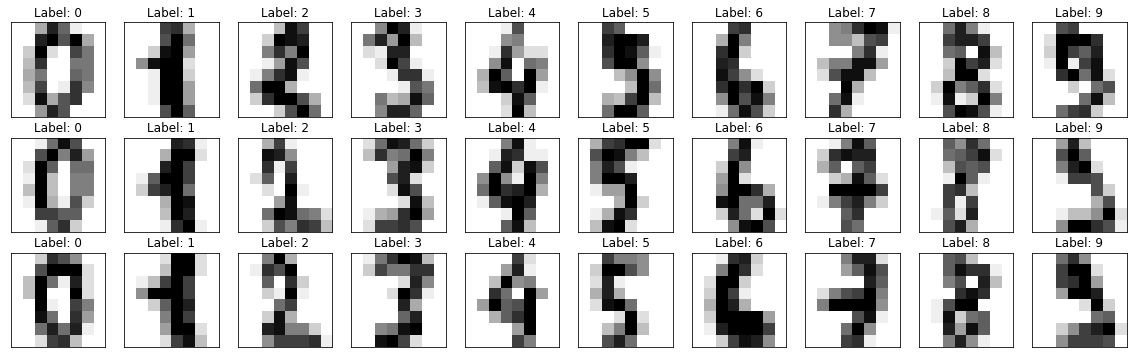

In [3]:
def show_images(data, targets):
    fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 6))
    for i in range(3):
        for l in range(10):
            axes[i, l].imshow(data[targets==l][i,:,:], cmap=plt.cm.gray_r)
            axes[i, l].set_xticks([])
            axes[i, l].set_yticks([])
            axes[i, l].set_title(f"Label: {targets[targets==l][i]}")

mnist = datasets.load_digits()
show_images(mnist.images, mnist.target)


In [4]:
def prepare_dataset(labels, num_instances, test_ratio, seed):
    mnist = datasets.load_digits()
    num_classes = len(labels)

    # Filter digits and targets
    x = mnist.images[[t in labels for t in mnist.target]]
    y = mnist.target[[t in labels for t in mnist.target]]

    # We keep only `num_instances` images for each label
    x = np.concatenate([x[y == labels[lbl]][:num_instances] for lbl in labels], axis=0)
    y = np.concatenate([y[y == labels[lbl]][:num_instances] for lbl in labels], axis=0)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=seed, stratify=y)

    return x_train, x_test, y_train, y_test

def image_resize(x, size):
    # https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
    return np.vstack([[resize(x_i, (size, 1), anti_aliasing=False) for x_i in x]])


In [5]:
labels = [0, 1]
num_instances = 50
test_ratio = 0.2
seed = 3897

x_train_8x8, x_test_8x8, y_train, y_test = prepare_dataset(labels, num_instances, test_ratio, seed)

In [6]:
feature_dim = 4
x_train_4x1 = image_resize(x_train_8x8, feature_dim)
x_test_4x1 = image_resize(x_test_8x8, feature_dim)

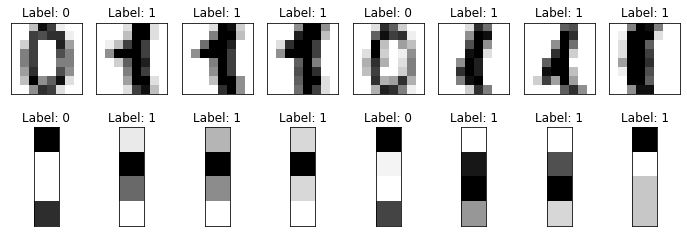

In [7]:
num_samples = 8
sources = [x_train_8x8, x_train_4x1]
fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(12, 4))
for i in range(num_samples):
    for s in range(len(sources)):
        axes[s, i].imshow(sources[s][i,:,:], cmap=plt.cm.gray_r)
        axes[s, i ].set_xticks([])
        axes[s, i].set_yticks([])
        axes[s, i].set_title(f"Label: {y_train[i]}")

# Data embedding circuits

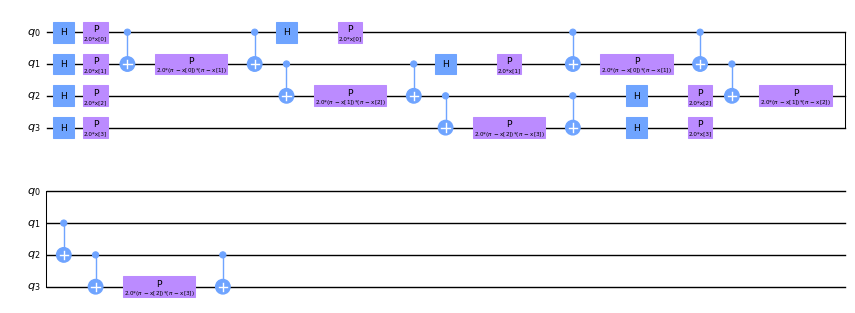

In [8]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent):
    return ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_zz = get_zz_feature_map(feature_dim, 2, 'linear')
fmap_zz.decompose().draw('mpl', scale=0.7)

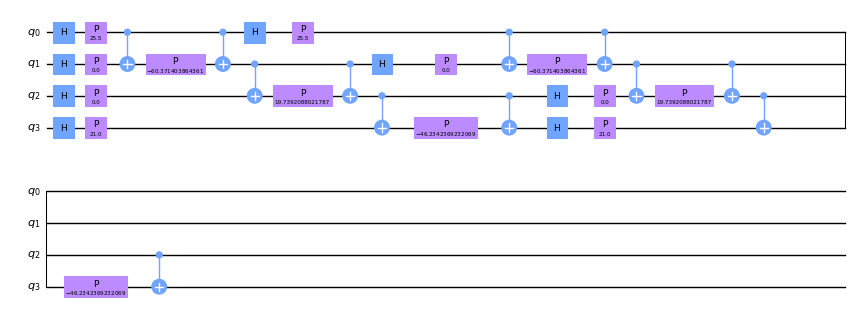

In [9]:
# Reshape input data size from (4,1) to (4,)
x_train_4 = x_train_4x1.reshape(x_train_4x1.shape[:-1])
x_test_4 = x_test_4x1.reshape(x_test_4x1.shape[:-1])

fmap_zz.assign_parameters({k:v for (k,v) in zip(fmap_zz.parameters, x_train_4[0])}).decompose().draw('mpl', scale=0.7)

# Anstaz

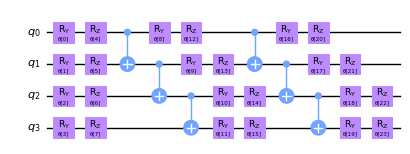

In [10]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(feature_dim, ['ry', 'rz'], 2, 'linear')
ansatz_tl.decompose().draw('mpl', scale=0.7)

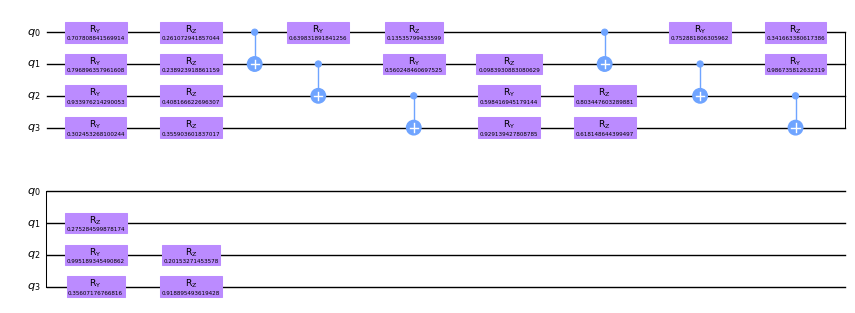

In [11]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=0.7)

# Quantum Neural Network

## CircuitQNN

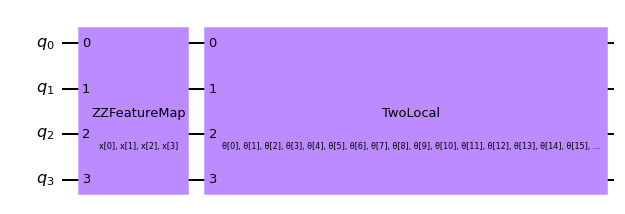

In [12]:
var_circuit = fmap_zz.compose(ansatz_tl)
var_circuit.draw('mpl')

In [13]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [14]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

### Forward pass

In [15]:
# The result of the neural network of the shape (output_shape).
output = qnn.forward(x_train_4[0], weights)
print(output.shape)
output

(1, 2)


array([[0.31445312, 0.68554688]])

### Backward pass

In [16]:
# The result of the neural network of the backward pass, i.e., a tuple with the gradients
# for input and weights of shape (output_shape, num_input) and
# (output_shape, num_weights), respectively.
_, update = qnn.backward(x_train_4[0], weights)
update

array([[[-4.32128906e-02,  3.14941406e-02,  4.41894531e-02,
          2.92968750e-03, -2.31933594e-02, -8.91113281e-02,
          7.32421875e-03,  6.10351562e-03,  1.94335938e-01,
         -5.85937500e-03, -2.92968750e-03, -1.07421875e-02,
         -1.22070313e-03, -1.09863281e-01,  1.24511719e-02,
          4.88281250e-04,  3.02978516e-01,  3.66210938e-03,
          6.34765625e-03,  1.39160156e-02, -8.67361738e-19,
          3.90625000e-03,  4.15039063e-03, -4.63867187e-03],
        [ 4.32128906e-02, -3.14941406e-02, -4.41894531e-02,
         -2.92968750e-03,  2.31933594e-02,  8.91113281e-02,
         -7.32421875e-03, -6.10351562e-03, -1.94335938e-01,
          5.85937500e-03,  2.92968750e-03,  1.07421875e-02,
          1.22070313e-03,  1.09863281e-01, -1.24511719e-02,
         -4.88281250e-04, -3.02978516e-01, -3.66210938e-03,
         -6.34765625e-03, -1.39160156e-02,  3.12250226e-17,
         -3.90625000e-03, -4.15039062e-03,  4.63867187e-03]]])

## OpflowQNN

In [17]:
obs_parity = Z ^ feature_dim
obs_one_qubit = I ^ (feature_dim - 1) ^ Z
obs_one_qubit

PauliOp(Pauli('IIIZ'), coeff=1.0)

In [18]:
# For an introduction to the Opflow module, see
# https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/operators/01_operator_flow.ipynb
operator = ~StateFn(obs_one_qubit) @ StateFn(var_circuit)
operator

ComposedOp([OperatorStateFn(PauliOp(Pauli('IIIZ'), coeff=1.0), coeff=1.0, is_measurement=True), CircuitStateFn(<qiskit.circuit.library.data_preparation.zz_feature_map.ZZFeatureMap object at 0x000002BC4F5F4D00>, coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False)

In [19]:
gradient = Gradient(grad_method="param_shift")
op_qnn = OpflowQNN(operator,
                   input_params=fmap_zz.parameters,
                   weight_params=ansatz_tl.parameters,
                   gradient=gradient,
                   quantum_instance=qinst)

### Forward pass

In [20]:
output = op_qnn.forward(x_train_4[0], weights)
print(output.shape)
output

(1, 1)


array([[-0.41503906]])

### Backward pass

In [21]:
_, update = op_qnn.backward(x_train_4[0], weights)
print(update.shape)
update

(1, 1, 24)


array([[[-1.04003906e-01,  5.02929688e-02,  8.83789062e-02,
         -5.37109375e-03, -6.39648438e-02, -1.67968750e-01,
         -2.44140625e-03, -9.76562500e-04,  4.19433594e-01,
         -1.17187500e-02, -4.88281250e-04, -1.56250000e-02,
          1.31835937e-02, -2.32910156e-01, -7.32421875e-03,
         -7.81250000e-03,  5.92773438e-01, -9.27734375e-03,
          4.88281250e-04,  1.90429688e-02, -3.12500000e-02,
          2.39257812e-02,  1.12304687e-02, -3.90625000e-03]]])

# Train a Neural Network Classifier with CircuitQNN

In [22]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [23]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [24]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


x_train_4_norm = np.array([x/np.linalg.norm(x) for x in x_train_4])

vqc = vqc.fit(x_train_4_norm, y_train_1h)

3 - 76.90365461913385
6 - 76.98926620009829
9 - 73.05162540742637
12 - 65.19405540015127
15 - 63.265326749569155
18 - 72.43280938219972
21 - 72.08129463791064
24 - 71.71644172557825
27 - 68.44221260859261
30 - 66.48797676039695
33 - 65.20449230561981
36 - 57.702597298384255
39 - 58.43069220374708
42 - 57.66058555287282
45 - 57.82124888661427
48 - 54.64681601662099
51 - 53.24026894220675
54 - 47.51575254469675
57 - 47.26737947205196
60 - 47.40568763895281
63 - 46.43749811590435
66 - 46.372287918619584
69 - 45.76426773306167
72 - 45.68783582181009
75 - 43.837904113959496
78 - 43.37380719099487
81 - 43.05080110514703
84 - 43.08316889154952
87 - 42.575525685535446
90 - 42.55929855514861
93 - 42.30059322582868
96 - 42.549857350043666
99 - 42.669570776383
102 - 42.07707348810983
105 - 41.749236253942385
108 - 41.97669261440258
111 - 41.75808622485466
114 - 41.81339816604927
117 - 41.7493024922931
120 - 41.535239193362486
123 - 41.51964797340974
126 - 41.46651732968122
129 - 41.58459734988116

In [25]:
score_train = vqc.score(x_train_4, y_train_1h)
score_test = vqc.score(x_test_4, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.525
Score on the test set 0.5


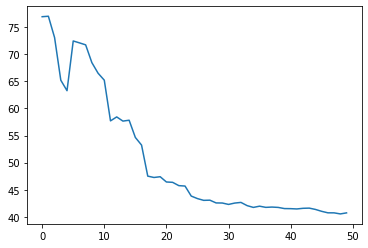

In [26]:
plt.plot(loss_recorder)

# Train a Neural Network Classifier with OpflowQNN and Gradient Descent

In [27]:
y_train_pm = np.array([-1 if y==0 else y for y in y_train])
y_test_pm = np.array([-1 if y==0 else y for y in y_test])
y_train.shape

(80,)

In [28]:
max_itr = 10
gd_opt = GradientDescent(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
op_vqc = NeuralNetworkClassifier(neural_network=op_qnn,
                                 loss=L2Loss(),
                                 one_hot=False,
                                 optimizer=gd_opt,
                                 initial_point=initial_point)

op_vqc = op_vqc.fit(x_train_4, y_train_pm)

1 - 78.69430160522461
2 - 78.02016735076904
3 - 77.18548393249512
4 - 76.28427314758301
5 - 76.75410652160645
6 - 75.70061206817627
7 - 75.4605541229248
8 - 75.5174207687378
9 - 75.83129596710205
10 - 74.8824110031128


In [29]:
score_train = op_vqc.score(x_train_4, y_train_pm)
score_test = op_vqc.score(x_test_4, y_test_pm)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.5875
Score on the test set 0.5


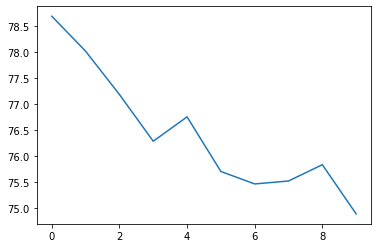

In [30]:
plt.plot(loss_recorder)